In [2]:
import os
import shutil
from google.colab import drive

print("Cleaning up broken connection points...")

!umount -f /content/drive


if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive')
    print("Deleted blocked directory.")


os.makedirs('/content/drive')
print("Created fresh directory.")


print("Attempting to mount...")
drive.mount('/content/drive')


if os.path.exists("/content/drive/MyDrive/housing_project/train_images"):
    count = len(os.listdir("/content/drive/MyDrive/housing_project/train_images"))
    print(f"\nSUCCESS: Drive connected! You have {count} images ready.")
else:
    print("\nDrive connected, but 'housing_project' folder not found yet.")

Cleaning up broken connection points...
umount: /content/drive: no mount point specified.
Created fresh directory.
Attempting to mount...
Mounted at /content/drive

SUCCESS: Drive connected! You have 16110 images ready.


In [3]:
import numpy as np
import pandas as pd
import os
import time
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
print("VGG16 Model Loaded successfully.")

def extract_features_batch(df, img_folder, output_csv):
    print(f"--- Processing {len(df)} images from {img_folder} ---")

    if os.path.exists(output_csv):
        print(f"Resuming from {output_csv}...")
        existing_df = pd.read_csv(output_csv)
        processed_ids = set(existing_df['id'].astype(str))
    else:
        existing_df = pd.DataFrame()
        processed_ids = set()

    new_features = []
    new_ids = []

    count = 0
    start_time = time.time()

    for index, row in df.iterrows():
        house_id = str(row['id'])

        if house_id in processed_ids:
            continue

        img_path = os.path.join(img_folder, f"house_{house_id}.png")

        try:
            if os.path.exists(img_path):

                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)


                feat = base_model.predict(x, verbose=0).flatten()
            else:

                feat = np.zeros(512)

            new_features.append(feat)
            new_ids.append(house_id)
            count += 1


            if count % 500 == 0:

                batch_df = pd.DataFrame(new_features)
                batch_df['id'] = new_ids


                header = not os.path.exists(output_csv)
                batch_df.to_csv(output_csv, mode='a', header=header, index=False)

                print(f"Saved {count} new images... (Time: {time.time()-start_time:.1f}s)")


                new_features = []
                new_ids = []

        except Exception as e:
            print(f"Error on {house_id}: {e}")

    if len(new_features) > 0:
        batch_df = pd.DataFrame(new_features)
        batch_df['id'] = new_ids
        header = not os.path.exists(output_csv)
        batch_df.to_csv(output_csv, mode='a', header=header, index=False)
        print("Final batch saved.")


train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
TRAIN_IMG_DIR = "/content/drive/MyDrive/housing_project/train_images"
TRAIN_OUT = "/content/drive/MyDrive/housing_project/train_features_vgg.csv"

extract_features_batch(train_df, TRAIN_IMG_DIR, TRAIN_OUT)


test_df = pd.read_csv("/content/drive/MyDrive/test.csv")
TEST_IMG_DIR = "/content/drive/MyDrive/housing_project/test_images"
TEST_OUT = "/content/drive/MyDrive/housing_project/test_features_vgg.csv"

extract_features_batch(test_df, TEST_IMG_DIR, TEST_OUT)

VGG16 Model Loaded successfully.
--- Processing 16209 images from /content/drive/MyDrive/housing_project/train_images ---
Resuming from /content/drive/MyDrive/housing_project/train_features_vgg.csv...
Saved 500 new images... (Time: 520.5s)
Saved 1000 new images... (Time: 1038.4s)
Saved 1500 new images... (Time: 1564.9s)
Saved 2000 new images... (Time: 2091.9s)
Saved 2500 new images... (Time: 2615.5s)
Saved 3000 new images... (Time: 3126.8s)
Saved 3500 new images... (Time: 3586.0s)
Saved 4000 new images... (Time: 4035.6s)
Saved 4500 new images... (Time: 4493.5s)
Saved 5000 new images... (Time: 4942.9s)
Saved 5500 new images... (Time: 5394.8s)
Saved 6000 new images... (Time: 5849.6s)
Saved 6500 new images... (Time: 6308.2s)
Saved 7000 new images... (Time: 6761.3s)
Saved 7500 new images... (Time: 7205.5s)
Saved 8000 new images... (Time: 7653.3s)
Final batch saved.
--- Processing 5404 images from /content/drive/MyDrive/housing_project/test_images ---
Saved 500 new images... (Time: 449.3s)


In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


print("Loading Tabular Data...")
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")

train_df['is_renovated'] = train_df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
test_df['is_renovated'] = test_df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

print("Loading Image Features...")
train_feats = pd.read_csv("/content/drive/MyDrive/housing_project/train_features_vgg.csv")
test_feats = pd.read_csv("/content/drive/MyDrive/housing_project/test_features_vgg.csv")

train_df['id'] = train_df['id'].astype(str)
test_df['id'] = test_df['id'].astype(str)
train_feats['id'] = train_feats['id'].astype(str)
test_feats['id'] = test_feats['id'].astype(str)

train_full = pd.merge(train_df, train_feats, on='id')
test_full = pd.merge(test_df, test_feats, on='id')

print(f"Training Data Shape: {train_full.shape}")
print(f"Test Data Shape: {test_full.shape}")

numeric_cols = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot',
                'floors', 'waterfront', 'view','condition','grade',
                'sqft_basement','lat','long','sqft_living15','is_renovated','yr_built']


image_cols = [str(i) for i in range(512)]

# Combine features
features = numeric_cols + image_cols
target = 'price'

X = train_full[features]
y = np.log1p(train_full[target])

print("Training Multimodal XGBoost...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

early_stop = xgb.callback.EarlyStopping(rounds=50, save_best=True)

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42,
    callbacks=[early_stop]
)


model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

preds_val = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(preds_val)))
r2 = r2_score(np.expm1(y_val), np.expm1(preds_val))

print(f"\nFinal Multimodal RMSE: ${rmse:,.2f}")
print(f"Final Multimodal R² Score: {r2:.4f}")

print("Generating Final Predictions...")
X_test = test_full[features]
test_preds_log = model.predict(X_test)
test_preds = np.expm1(test_preds_log)

submission = pd.DataFrame({
    'id': test_full['id'],
    'predicted_price': test_preds
})

submission.to_csv("/content/drive/MyDrive/housing_project/final_predictions.csv", index=False)
print("Saved final_predictions.csv!")

Loading Tabular Data...
Loading Image Features...
Training Data Shape: (16289, 534)
Test Data Shape: (5420, 533)
Training Multimodal XGBoost...
[0]	validation_0-rmse:0.50057
[100]	validation_0-rmse:0.17635
[200]	validation_0-rmse:0.17215
[300]	validation_0-rmse:0.17117
[400]	validation_0-rmse:0.17115
[466]	validation_0-rmse:0.17110

Final Multimodal RMSE: $132,645.88
Final Multimodal R² Score: 0.8723
Generating Final Predictions...
Saved final_predictions.csv!


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_40']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


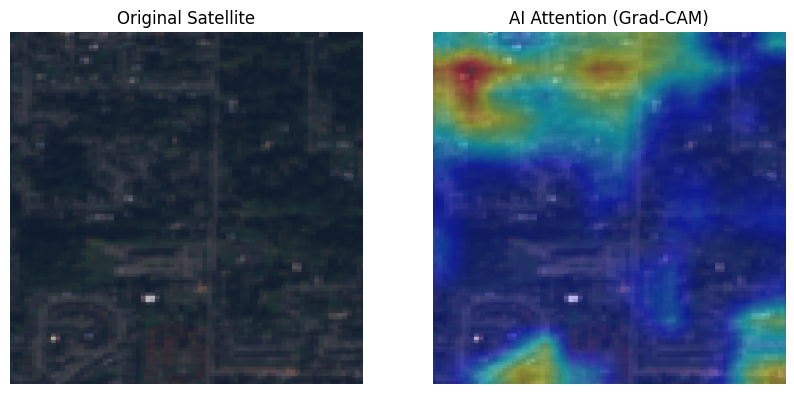

In [9]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=True)
last_conv_layer_name = "block5_conv3"

grad_model = Model(
    inputs=base_model.inputs,
    outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
)

def make_gradcam_heatmap(img_array, model, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

test_id = "9117000170"
img_path = f"/content/drive/MyDrive/housing_project/train_images/house_{test_id}.png"

if os.path.exists(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, grad_model)


    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_colored * 0.4 + img_cv

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("AI Attention (Grad-CAM)")
    plt.axis('off')
    plt.show()
else:
    print(f"Image {img_path} not found.")

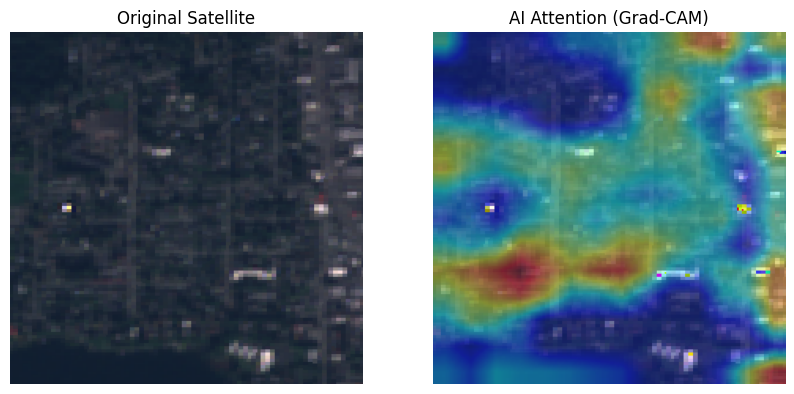

In [10]:
test_id = "9900000190"
img_path = f"/content/drive/MyDrive/housing_project/train_images/house_{test_id}.png"

if os.path.exists(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, grad_model)


    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_colored * 0.4 + img_cv

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("AI Attention (Grad-CAM)")
    plt.axis('off')
    plt.show()
else:
    print(f"Image {img_path} not found.")

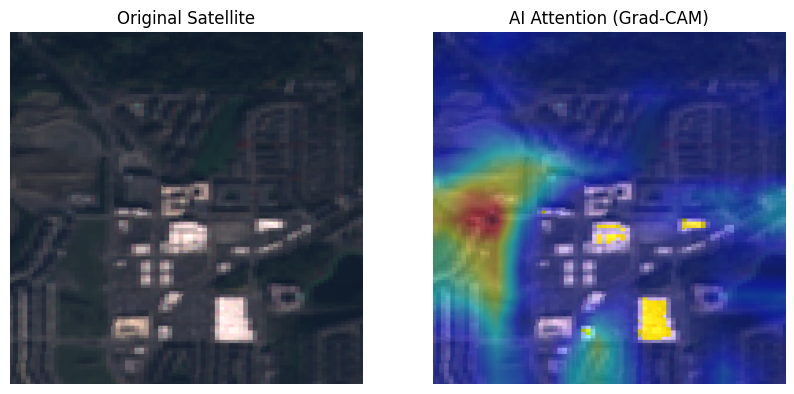

In [11]:
test_id = "9895000040"
img_path = f"/content/drive/MyDrive/housing_project/train_images/house_{test_id}.png"

if os.path.exists(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, grad_model)


    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_colored * 0.4 + img_cv

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("AI Attention (Grad-CAM)")
    plt.axis('off')
    plt.show()
else:
    print(f"Image {img_path} not found.")

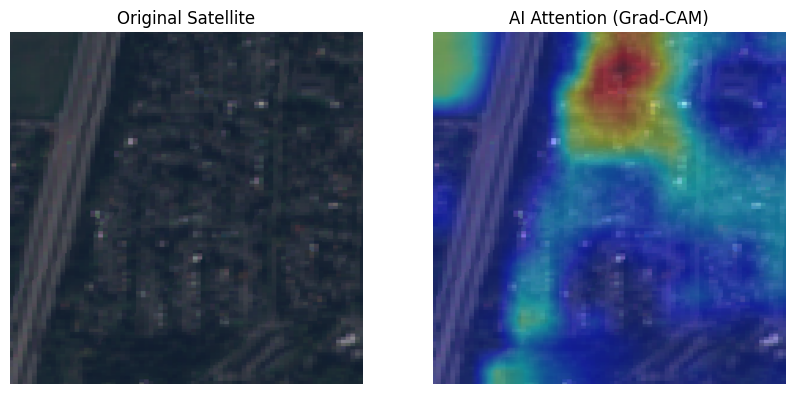

In [12]:
test_id = "9835801000"
img_path = f"/content/drive/MyDrive/housing_project/train_images/house_{test_id}.png"

if os.path.exists(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, grad_model)


    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_colored * 0.4 + img_cv

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("AI Attention (Grad-CAM)")
    plt.axis('off')
    plt.show()
else:
    print(f"Image {img_path} not found.")

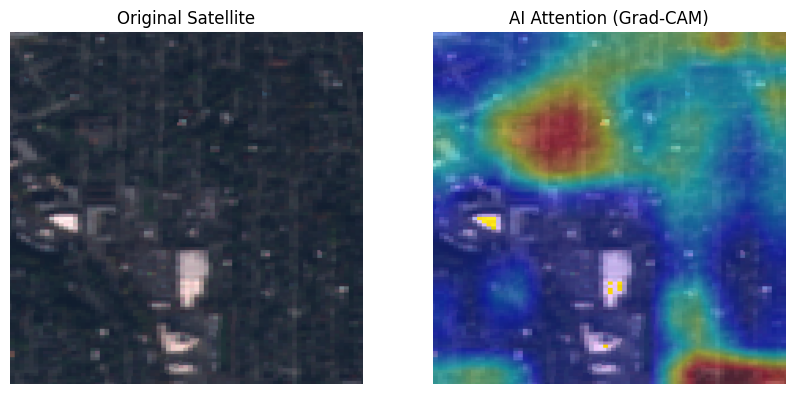

In [13]:
test_id = "9834201470"
img_path = f"/content/drive/MyDrive/housing_project/train_images/house_{test_id}.png"

if os.path.exists(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, grad_model)


    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_colored * 0.4 + img_cv

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("AI Attention (Grad-CAM)")
    plt.axis('off')
    plt.show()
else:
    print(f"Image {img_path} not found.")

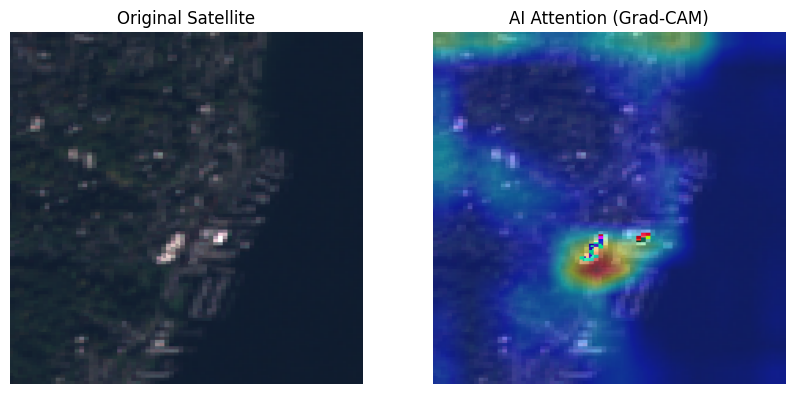

In [15]:
test_id = "9829200590"
img_path = f"/content/drive/MyDrive/housing_project/train_images/house_{test_id}.png"

if os.path.exists(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, grad_model)


    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_colored * 0.4 + img_cv

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("AI Attention (Grad-CAM)")
    plt.axis('off')
    plt.show()
else:
    print(f"Image {img_path} not found.")